In [2]:
import sys
sys.path.append('..')

In [3]:
import os
os.environ['TOKENIZERS_PARALLELISM']='true'
os.environ['CUDA_VISIBLE_DEVICES']='2'

In [4]:
import re
import os
import torch
import json
import numpy as np
import pandas as pd
import seaborn as sns
import transformers
import catalyst
import difflib
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from transformers import T5Tokenizer, T5TokenizerFast, T5ForConditionalGeneration
from transformers.tokenization_utils import PreTrainedTokenizer
from transformers.tokenization_utils_fast import PreTrainedTokenizerFast
from typing import Callable, Union, Tuple
from catalyst.loggers.wandb import WandbLogger
from tqdm.notebook import tqdm
from collections import Counter
from torch import nn
from catalyst import dl
from catalyst.callbacks.periodic_loader import PeriodicLoaderCallback
from langdetect import detect
from easse.sari import corpus_sari
from rouge import Rouge

In [5]:
from dataclasses import dataclass

@dataclass
class Config:
    pass

CONFIG = Config()
CONFIG.seed = 1337

import random

random.seed(CONFIG.seed)
os.environ['PYTHONHASHSEED'] = str(CONFIG.seed)
np.random.seed(CONFIG.seed)
torch.manual_seed(CONFIG.seed)
torch.cuda.manual_seed(CONFIG.seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

## Model

In [6]:
import torch
from transformers import CodeGenForCausalLM, AutoTokenizer
from transformers import RobertaTokenizer, T5ForConditionalGeneration

CONFIG.src_max_len = 512
CONFIG.tgt_max_len = 512
CONFIG.pretrained = 'Salesforce/codet5-small'

tokenizer = RobertaTokenizer.from_pretrained(CONFIG.pretrained)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = T5ForConditionalGeneration.from_pretrained(CONFIG.pretrained).to(device)

SEP_TOKEN = str(tokenizer.__dict__['init_kwargs']['sep_token'])

## Read data

In [7]:
import pandas as pd

df_new_disk = pd.read_json(r'final_data.json')
df_new_disk.shape

(74455, 10)

In [8]:
df_new_disk.head(2)

,code_before,code_after,commit_msg,com_py2imports_before,com_py2imports_after,diff,com_hash,imports,lib8funcs,docs
0,"def _misc(self, func, opts, args):\n ...","def _misc(self, func, opts, args):\n ...",http://code.google.com/p/pytyrant/issues/detai...,"{'0_pytyrant.py': ['import socket', 'import st...","{'0_pytyrant.py': ['import socket', 'import st...","@@ -493,8 +493,10 @@ class Tyrant(object):\n ...",32618ec0a7a05bad587064e20adfb80cb7bd1860,"[import UserDict, import struct, import socket]","[{'UserDict': '*', 'struct': '*', 'socket': '*...",[]
1,"def _tDouble(code, key, integ, fract):\n re...","def _tDouble(code, key, integ, fract):\n re...",fix adddouble typo,"{'0_pytyrant.py': ['import math', 'import sock...","{'0_pytyrant.py': ['import math', 'import sock...","@@ -147,7 +147,7 @@ def _t3F(code, func, opts,...",8b5d9f765a0fbbd76cc7b7ff8d2593436c6a2360,"[import struct, import UserDict, import math, ...","[{'struct': '*', 'UserDict': '*', 'math': '*',...",[Functions to convert between Python values an...


In [9]:
df_new_disk['file_name'] = df_new_disk['com_py2imports_after'].apply(lambda x: list(x)[0])

In [10]:
def generate_prompts(row):
    fn = row['file_name']
    code_before = row['code_before']
    commit_msg = row['commit_msg']
    return f'{commit_msg} {SEP_TOKEN} {code_before}\n'

In [11]:
df_new_disk['prompt'] = df_new_disk.apply(lambda x: generate_prompts(x), axis=1)

In [12]:
print(df_new_disk['prompt'].iloc[100])

Fix RBF features. </s>     def __init__(self, nrows = 5, ncols = 5, walls=[(1,1),(1,2),(1,3),(2,1),(2,2),(2,3),(3,1),(3,2),(3,3)], endstates = [0]):
        self.nrows = nrows
        self.ncols = ncols

        self.walls = walls
        grid = [self.coords(i) for i in range(self.nrows * self.ncols)]
        grid = [s for s in grid if not s in self.walls]
        self.states = dict([(i,s) for (i,s) in enumerate(grid)])
        self.rstates = dict([(s,i) for (i,s) in enumerate(grid)]) # reverse lookup by grid coords

        self.nstates = len(self.states)
        self.nactions = 8
        self.endstates = endstates

        MDP.__init__(self, nstates = self.nstates, nactions = self.nactions)



In [13]:
with open('train_idxs.npy', 'rb') as f:
    X_train_idx = np.load(f)
    
with open('test_idxs.npy', 'rb') as f:
    X_test_idx = np.load(f)

In [14]:
X_train = df_new_disk.iloc[X_train_idx]
X_test = df_new_disk.iloc[X_test_idx]
X_test_sub = X_test.iloc[:600]

In [15]:
X_train.shape, X_test.shape, X_test_sub.shape

((67009, 12), (7446, 12), (600, 12))

## Dataset

In [16]:
from typing import Union, Callable, Tuple
from transformers.tokenization_utils import PreTrainedTokenizer
from transformers.tokenization_utils_fast import PreTrainedTokenizerFast

class EditDataset(torch.utils.data.Dataset):
    def __init__(self, 
                 dataset: pd.DataFrame, 
                 tokenizer: Union[PreTrainedTokenizer, PreTrainedTokenizerFast],
                 config):
        self.db = dataset
        self.tokenizer = tokenizer
        
        src_text = self.db['prompt'].values
        tgt_text = self.db['code_after'].values
        
        self.src_text_tokenized = [tokenizer(x,
                                       max_length=config.src_max_len,
                                       truncation=True,
                                       return_attention_mask=False,
                                       ) for x in src_text]
        self.tgt_text_tokenized = [tokenizer(x,
                                       max_length=config.tgt_max_len,
                                       truncation=True,
                                       return_attention_mask=False,
                                       ) for x in tgt_text]

    def __len__(self):
        return len(self.db)

    def __getitem__(self, 
                    idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        src = self.src_text_tokenized[idx]
        tgt = self.tgt_text_tokenized[idx]
        return src, tgt
    
    @staticmethod
    def collate_fn_new(samples: Tuple[torch.Tensor, torch.Tensor], 
                   tokenizer: Union[PreTrainedTokenizer, PreTrainedTokenizerFast], 
                   config: Config) -> Tuple[Tuple[torch.Tensor, torch.Tensor], torch.Tensor]:
        src_samples = [x[0] for x in samples]
        tgt_samples = [x[1] for x in samples]

        src_samples = tokenizer.pad(src_samples,
                                    padding='longest',
                                    max_length=config.src_max_len,
                                    return_attention_mask=False,
                                    return_tensors='pt')['input_ids']

        tgt_samples = tokenizer.pad(tgt_samples,
                                    padding='longest',
                                    max_length=config.tgt_max_len,
                                    return_attention_mask=False,
                                    return_tensors='pt')['input_ids']

        return (src_samples, tgt_samples), tgt_samples

In [17]:
train_ds = EditDataset(X_train, tokenizer, CONFIG)
test_ds = EditDataset(X_test, tokenizer, CONFIG)
test_ds_sub = EditDataset(X_test_sub, tokenizer, CONFIG)

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

**Len distribution**

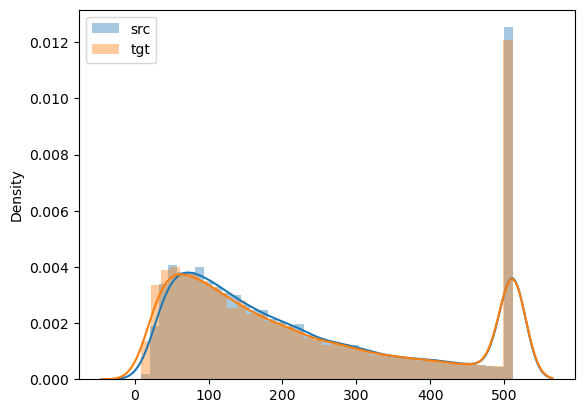

In [19]:
arr_src = []
arr_tgt = []
for src_q, tgt_q in train_ds:
    arr_src.append(len(src_q['input_ids']))
    arr_tgt.append(len(tgt_q['input_ids']))

sns.distplot(arr_src, label='src');
plt.legend();
sns.distplot(arr_tgt, label='tgt');
plt.legend();

## Model training

In [20]:
CONFIG.batch_size = 4
loaders = {
    'train': torch.utils.data.DataLoader(train_ds, 
                                         batch_size=CONFIG.batch_size,
                                         collate_fn=lambda x: EditDataset.collate_fn_new(x, tokenizer, CONFIG),
                                         num_workers=4, shuffle=True),
    'valid_full': torch.utils.data.DataLoader(test_ds, 
                                         batch_size=CONFIG.batch_size,
                                         collate_fn=lambda x: EditDataset.collate_fn_new(x, tokenizer, CONFIG),
                                         num_workers=4, shuffle=False),
    'valid_subset': torch.utils.data.DataLoader(test_ds_sub, 
                                         batch_size=CONFIG.batch_size,
                                         collate_fn=lambda x: EditDataset.collate_fn_new(x, tokenizer, CONFIG),
                                         num_workers=4, shuffle=False)
}

In [21]:
class EditModel(nn.Module):
    def __init__(self, 
                 pretrained: transformers.modeling_utils.PreTrainedModel, 
                 config: Config):
        super(EditModel, self).__init__()
        self.pretrained = pretrained
        

    def forward(self, 
                x: Tuple[torch.Tensor, torch.Tensor]):
        src, tgt = x
        
        tgt[tgt == 0] == -100
        
        loss = self.pretrained(
            input_ids = src,
            attention_mask = (src != 0).float(),
            labels=tgt,
        ).loss
        return loss
    
    
class Criterion(nn.Module):
    def __init__(self):
        super(Criterion, self).__init__()
        
    def forward(self, pred, tgt):
        return pred

In [22]:
model = EditModel(
    T5ForConditionalGeneration.from_pretrained(CONFIG.pretrained),
    CONFIG
)
CONFIG.optimizer = 'Adam(lr=0.0001)'
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

CONFIG.name = f'{CONFIG.pretrained}'
CONFIG.description = f'{CONFIG.name} p(x_t+1 | x_t, commit_msg)'
CONFIG.group = "code_edit"

In [23]:
!rm -rf ./models/"{CONFIG.description}"

In [24]:
from catalyst.core import IRunner
from catalyst.metrics._additive import AdditiveMetric
from catalyst.callbacks.metric import BatchMetricCallback, ICallbackBatchMetric


class AccMetric(ICallbackBatchMetric):
    def __init__(self, topk, compute_on_call=False):
        super().__init__(compute_on_call=compute_on_call, prefix='', suffix='')
        self.metric_name = 'sql_acc'
        self.topk = topk
        self.metrics: List[AdditiveMetric] = [
            AdditiveMetric(compute_on_call=compute_on_call) for _ in range(len(self.topk))]

    def reset(self) -> None:
        for metric in self.metrics:
            metric.reset()

    def update(self, values, n_samples):
        for value, metric in zip(values, self.metrics):
            metric.update(value, n_samples)
        return values

    def update_key_value(self, values, n_samples):
        values = self.update(values, n_samples)
        output = {
            f"{self.prefix}{self.metric_name}{key:02d}{self.suffix}": round(value, 6)
            for key, value in zip(self.topk, values)
        }
        return output

    def compute(self):
        means, stds = zip(*(metric.compute() for metric in self.metrics))
        return means, stds

    def compute_key_value(self):
        means, stds = self.compute()
        output_mean = {
            f"{self.prefix}{self.metric_name}{key:02d}{self.suffix}": round(value, 6)
            for key, value in zip(self.topk, means)
        }
        output_std = {
            f"{self.prefix}{self.metric_name}{key:02d}{self.suffix}/std": round(value, 6)
            for key, value in zip(self.topk, stds)
        }
        return {**output_mean, **output_std}


class AccCallback(BatchMetricCallback):

    def __init__(self, beam_size):
        super().__init__(
            metric=AccMetric((1,beam_size)) if beam_size > 1 else AccMetric((1,)),
            input_key='features', target_key='targets', log_on_batch=True)
        self.beam_size = beam_size

    def on_batch_end(self, runner: "IRunner") -> None:

        if runner.loader_key == 'train':
            runner.model.train()
        elif runner.loader_key.startswith('valid'):
            runner.model.eval()

            src = runner.batch['features'][0]
            tgt = runner.batch['features'][1]
            max_len = tgt.shape[1]
            with torch.no_grad():
                pred = runner.model.pretrained.generate(src.to(runner.engine.device),
                                                        attention_mask=(src != 0).float().to(runner.engine.device),
                                                        # pad_token_id=tokenizer.pad_token_id,
                                                        # bos_token_id=tokenizer.bos_token_id,
                                                        # eos_token_id=tokenizer.eos_token_id,
                                                        num_beams=self.beam_size,
                                                        num_return_sequences=self.beam_size,
                                                        max_length=max_len
                                                        )

            pred = pred[:,1:]
            pred = pred.view(-1, self.beam_size, pred.shape[1])
            acck = 0
            acc1 = 0
            for i in range(tgt.shape[0]):
                tgt_subseq = tgt[i, :pred.shape[2]].to(runner.engine.device)

                acck += float(torch.any(torch.all(tgt_subseq == pred[i], dim=1)))
                acc1 += float(torch.all(tgt_subseq == pred[i, 0]))

            acck /= len(src)
            acc1 /= len(src)

            metrics = self.metric.update_key_value([acc1, acck], len(src))

            runner.batch_metrics.update(metrics)

    def on_loader_end(self, runner: "IRunner") -> None:
        if runner.loader_key.startswith('valid'):
            metrics = self.metric.compute_key_value()
            metrics = runner.engine.mean_reduce_ddp_metrics(metrics)
            runner.loader_metrics.update(metrics)

In [25]:
CONFIG.n_epochs = 300

In [ ]:
runner = dl.SupervisedRunner()

wandb_logger = WandbLogger(project="interactive_lm", 
                              name=CONFIG.name, 
                              group=CONFIG.group)

runner.train(
    loaders=loaders,
    model=model,
    criterion=Criterion(),
    optimizer=optimizer,
    num_epochs=CONFIG.n_epochs,
    callbacks=[
        PeriodicLoaderCallback(
            valid_loader_key='valid_full',
            valid_metric_key='loss',
            minimize=True,
            **{'valid_full': 10}
        ),
        AccCallback(2),
        #dl.optimizer.OptimizerCallback(metric_key='loss', accumulation_steps=),
    ],
    loggers={'wandb': wandb_logger},
    logdir=f'./models/{CONFIG.description}',
    valid_loader='valid_subset',
    valid_metric='loss',
    minimize_valid_metric=True,
    verbose=True,
#     check=True,
#     cpu=True,
)

wandb: Currently logged in as: anton-sh. Use `wandb login --relogin` to force relogin


1/300 * Epoch (train):   0%|          | 0/16753 [00:00<?, ?it/s]

train (1/300) loss: 0.24135010012855293 | loss/mean: 0.24135010012855293 | loss/std: 0.19018236455019433 | lr: 0.0001 | momentum: 0.9


1/300 * Epoch (valid_subset):   0%|          | 0/150 [00:00<?, ?it/s]

valid_subset (1/300) loss: 0.1954269914204875 | loss/mean: 0.1954269914204875 | loss/std: 0.15844029615603947 | lr: 0.0001 | momentum: 0.9 | sql_acc01: 0.073333 | sql_acc01/std: 0.130961 | sql_acc02: 0.095 | sql_acc02/std: 0.146381
* Epoch (1/300) 


2/300 * Epoch (train):   0%|          | 0/16753 [00:00<?, ?it/s]

train (2/300) loss: 0.19320577546202128 | loss/mean: 0.19320577546202128 | loss/std: 0.1511303547207014 | lr: 0.0001 | momentum: 0.9


2/300 * Epoch (valid_subset):   0%|          | 0/150 [00:00<?, ?it/s]

valid_subset (2/300) loss: 0.1788516067278882 | loss/mean: 0.1788516067278882 | loss/std: 0.14573245288344763 | lr: 0.0001 | momentum: 0.9 | sql_acc01: 0.08 | sql_acc01/std: 0.133403 | sql_acc02: 0.106667 | sql_acc02/std: 0.148298
* Epoch (2/300) 


3/300 * Epoch (train):   0%|          | 0/16753 [00:00<?, ?it/s]

train (3/300) loss: 0.1750104712462276 | loss/mean: 0.1750104712462276 | loss/std: 0.1383602920874888 | lr: 0.0001 | momentum: 0.9


3/300 * Epoch (valid_subset):   0%|          | 0/150 [00:00<?, ?it/s]

valid_subset (3/300) loss: 0.17003107587185995 | loss/mean: 0.17003107587185995 | loss/std: 0.13805634173714432 | lr: 0.0001 | momentum: 0.9 | sql_acc01: 0.08 | sql_acc01/std: 0.130237 | sql_acc02: 0.111667 | sql_acc02/std: 0.143113
* Epoch (3/300) 


4/300 * Epoch (train):   0%|          | 0/16753 [00:00<?, ?it/s]

train (4/300) loss: 0.1624325444545755 | loss/mean: 0.1624325444545755 | loss/std: 0.13189375180935436 | lr: 0.0001 | momentum: 0.9


4/300 * Epoch (valid_subset):   0%|          | 0/150 [00:00<?, ?it/s]

valid_subset (4/300) loss: 0.16462270932272083 | loss/mean: 0.16462270932272083 | loss/std: 0.13633069073931722 | lr: 0.0001 | momentum: 0.9 | sql_acc01: 0.096667 | sql_acc01/std: 0.140909 | sql_acc02: 0.13 | sql_acc02/std: 0.154833
* Epoch (4/300) 


5/300 * Epoch (train):   0%|          | 0/16753 [00:00<?, ?it/s]

train (5/300) loss: 0.15189763804595713 | loss/mean: 0.15189763804595713 | loss/std: 0.12200039212764711 | lr: 0.0001 | momentum: 0.9


5/300 * Epoch (valid_subset):   0%|          | 0/150 [00:00<?, ?it/s]

valid_subset (5/300) loss: 0.16007237632138044 | loss/mean: 0.16007237632138044 | loss/std: 0.1329786070287323 | lr: 0.0001 | momentum: 0.9 | sql_acc01: 0.11 | sql_acc01/std: 0.148672 | sql_acc02: 0.136667 | sql_acc02/std: 0.164927
* Epoch (5/300) 


6/300 * Epoch (train):   0%|          | 0/16753 [00:00<?, ?it/s]

train (6/300) loss: 0.14348485877584763 | loss/mean: 0.14348485877584763 | loss/std: 0.11820195416869901 | lr: 0.0001 | momentum: 0.9


6/300 * Epoch (valid_subset):   0%|          | 0/150 [00:00<?, ?it/s]

valid_subset (6/300) loss: 0.1585418442077934 | loss/mean: 0.1585418442077934 | loss/std: 0.1304713340803188 | lr: 0.0001 | momentum: 0.9 | sql_acc01: 0.113333 | sql_acc01/std: 0.148972 | sql_acc02: 0.14 | sql_acc02/std: 0.164657
* Epoch (6/300) 


7/300 * Epoch (train):   0%|          | 0/16753 [00:00<?, ?it/s]